In [44]:
!pip install ttach
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [45]:
import os
import pathlib
import sys
import cv2

import numpy as np
import pandas as pd
from enum import Enum, auto

# Divers utilitaires
from collections import defaultdict
from tqdm import tqdm 
from PIL import Image
from typing import Callable, List, Optional, Tuple

# Outils de machine learning classique
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight

# Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

## Optuna
import optuna

## Gradcam
import ttach as tta

from torchcam.methods import GradCAM
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

In [3]:
def plot_confusion_matrix(cm, labels, normalize=False, title="Matrice de confusion", cmap="coolwarm"):
    """
    Affiche une matrice de confusion à l'aide de Seaborn.

    Args:
        cm (array): Matrice de confusion.
        labels (list): Liste des noms de classes (ordonnées et abscisses).
        normalize (bool): Si True, normalise par ligne et affiche les pourcentages.
        title (str): Titre du graphique.
        cmap (str): Palette de couleurs.
    """
    if normalize:
        # Normalisation ligne par ligne
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2%"  # Affichage sous forme de pourcentage XX.XX%
    else:
        fmt = "d"  # Entiers bruts

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=labels, yticklabels=labels)

    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()

In [34]:
def epoch_viewer(history: dict, style="whitegrid", engine="seaborn"):
    """
    Affiche les courbes d'apprentissage (accuracy et perte) à partir d'un dictionnaire d'historique.
    
    Args:
        history (dict): Dictionnaire contenant les listes des métriques par époque.
        style (str): Style graphique pour Seaborn.
        engine (str): "seaborn" ou "plotly" pour affichage.
    """
    if engine == "plotly":
        if "plotly" not in sys.modules:
            print("Plotly non installé, utilisation de Seaborn")
        else:
            fig = make_subplots(rows=1, cols=2, subplot_titles=["Accuracy", "Loss"])

            # Accuracy
            fig.add_trace(go.Scatter(x=list(range(len(history["accuracy"]))), y=history["accuracy"],
                                     mode="lines", name="Train Accuracy"), row=1, col=1)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_accuracy"]))), y=history["val_accuracy"],
                                     mode="lines", name="Validation Accuracy"), row=1, col=1)

            # Loss
            fig.add_trace(go.Scatter(x=list(range(len(history["loss"]))), y=history["loss"],
                                     mode="lines", name="Train Loss"), row=1, col=2)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_loss"]))), y=history["val_loss"],
                                     mode="lines", name="Validation Loss"), row=1, col=2)

            fig.update_layout(height=600, width=1500, title_text="Historique d'entraînement", template="plotly_white")
            fig.show()
            return
    else:
        sns.set_theme(style=style)
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))

        sns.lineplot(x=range(len(history["accuracy"])), y=history["accuracy"], label="acc", color="blue", ax=ax[0])
        sns.lineplot(x=range(len(history["val_accuracy"])), y=history["val_accuracy"], label="val acc", color="red", ax=ax[0])
        ax[0].set_title("Accuracy")
        ax[0].legend()

        sns.lineplot(x=range(len(history["loss"])), y=history["loss"], label="loss", color="blue", ax=ax[1])
        sns.lineplot(x=range(len(history["val_loss"])), y=history["val_loss"], label="val loss", color="red", ax=ax[1])
        ax[1].set_title("Loss")
        ax[1].legend()

        plt.tight_layout()

In [5]:
def define_paths(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Définit les chemins de fichiers et leurs étiquettes (labels) à partir d’un
    dossier principal. Possibilité d’exclure certains dossiers ou fichiers.

    Arguments :
        data_dir (str) : Chemin vers le dossier de données principal.
        exclude_dirs (list, optionnel) : Liste de noms de dossiers à exclure.
                                         Exemple : ['a_exclure'].
        exclude_files (list, optionnel) : Liste de fichiers à exclure (noms simples, sans chemin).
                                          Exemple : ['image_bug.jpg'].

    Retourne :
        tuple :
            - filepaths (list) : Liste des chemins absolus vers les fichiers valides.
            - labels (list) : Liste des étiquettes correspondantes (noms des dossiers parents).
    """
    filepaths = []
    labels = []

    # Si aucune liste d'exclusion n'est fournie, on utilise des listes vides
    if exclude_dirs is None:
        exclude_dirs = []
    if exclude_files is None:
        exclude_files = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        # Sauter les dossiers explicitement exclus
        if fold in exclude_dirs:
            print(f"Dossier exclu : {foldpath}")
            continue

        # Sauter les fichiers à la racine du dossier (on attend uniquement des sous-dossiers)
        if pathlib.Path(foldpath).suffix != '':
            continue

        # Liste des fichiers dans le dossier courant
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            file_basename = os.path.basename(fpath)

            # Exclure certains fichiers spécifiquement
            if file_basename in exclude_files:
                print(f"Fichier exclu : {fpath}")
                continue

            # Si on tombe sur un sous-dossier (par exemple "masks")
            if pathlib.Path(fpath).suffix == '':
                if pathlib.Path(fpath).parts[-1].lower() == 'masks':
                    print(f"Dossier de masques ignoré : {fpath}")
                    continue
                else:
                    # Parcours du contenu du sous-dossier
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        inner_file_basename = os.path.basename(ipath)

                        # Exclusion spécifique de fichiers internes
                        if inner_file_basename in exclude_files:
                            print(f"Fichier exclu (interne) : {ipath}")
                            continue

                        filepaths.append(ipath)
                        labels.append(fold)  # Étiquette = nom du dossier parent
            else:
                # Fichier directement dans le dossier principal
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels



def define_df(files, classes):
    """
    Crée un DataFrame pandas à partir de deux listes : les chemins et les labels.

    Arguments :
        files (list) : Liste des chemins vers les fichiers.
        classes (list) : Liste des étiquettes associées.

    Retourne :
        pd.DataFrame : Un tableau avec deux colonnes : 'filepaths' et 'labels'.
    """
    Fseries = pd.Series(files, name="filepaths")
    Lseries = pd.Series(classes, name="labels")
    return pd.concat([Fseries, Lseries], axis=1)



def split_data(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Divise l'ensemble des données en trois sous-ensembles : entraînement, validation et test.

    Arguments :
        data_dir (str) : Chemin vers le dossier principal contenant les données.
        exclude_dirs (list, optionnel) : Dossiers à ignorer.
        exclude_files (list, optionnel) : Fichiers à ignorer.

    Retourne :
        tuple :
            - train_df : Données pour l'entraînement.
            - valid_df : Données pour la validation.
            - test_df : Données pour le test final.
    """
    # Création des chemins de fichiers + labels (avec exclusions éventuelles)
    files, classes = define_paths(data_dir, exclude_dirs=exclude_dirs, exclude_files=exclude_files)
    df = define_df(files, classes)

    # Séparation en données d'entraînement et données restantes (20%)
    strat = df['labels']
    train_df, dummy_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=strat
    )

    # Séparation des 20% restants en validation et test
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(
        dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat
    )

    return train_df, valid_df, test_df


In [6]:
class ImageDatasetFromDF(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df["filepaths"].values
        self.labels = df["labels"].values
        self.transform = transform

        # Encoder les labels si besoin
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.targets = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_transforms(img_size=(240, 240)):
    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet
                             std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

def create_loaders(train_df, valid_df, test_df, batch_size=32, img_size=(240, 240)):
    """
    Crée les DataLoaders pour l'entraînement, la validation et le test (PyTorch).
    """
    train_tf, test_tf = get_transforms(img_size)

    train_ds = ImageDatasetFromDF(train_df, transform=train_tf)
    valid_ds = ImageDatasetFromDF(valid_df, transform=test_tf)
    test_ds = ImageDatasetFromDF(test_df, transform=test_tf)

    test_batch_size = min(len(test_df), batch_size * 2)  

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [7]:
def show_images_torch(loader, class_names=None, figsize=(20, 20)):
    images, labels = next(iter(loader))
    images = images[:25]
    labels = labels[:25]

    # De-normaliser pour affichage
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    images = images.permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        label = class_names[labels[i]] if class_names else labels[i].item()
        plt.title(label, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [8]:
def generate_loaders(img_size=(240, 240), exclude_dirs=None, batch_size=16):
    """
    Génère les DataLoaders PyTorch pour l'entraînement, la validation et le test.

    Args:
        img_size (tuple): Dimensions des images (largeur, hauteur).
        exclude_dirs (list, optionnel): Dossiers à exclure.
        batch_size (int): Taille des batchs.

    Retourne :
        tuple : (train_loader, valid_loader, test_loader)
    """
    data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

    try:
        train_df, valid_df, test_df = split_data(data_dir, exclude_dirs=exclude_dirs)
        train_loader, valid_loader, test_loader = create_loaders(
            train_df, valid_df, test_df,
            batch_size=batch_size,
            img_size=img_size
        )
        return train_loader, valid_loader, test_loader, train_df, valid_df, test_df
    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None, None, None, None, None, None



In [9]:
train_loader, valid_loader, test_loader, train_df, valid_df, test_df = generate_loaders()

Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks


In [10]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=4, fine_tune=False):
        super(EfficientNetClassifier, self).__init__()

        # Charger EfficientNetB0 avec poids ImageNet
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        self.base_model = efficientnet_b0(weights=weights)

        # Geler ou dégeler le backbone
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune

        # Extraire la taille de sortie du backbone
        in_features = self.base_model.classifier[1].in_features

        # Remplacer le classifieur final
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # On retire le classifier original
        self.base_model.classifier = nn.Identity()

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


In [11]:
model = EfficientNetClassifier(num_classes=4, fine_tune=False)
model.to("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s] 


EfficientNetClassifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
        

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilisé : {device}")

# Class weights
train_labels = train_df['labels'].values
class_names = np.unique(train_labels)
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
encoded_labels = [class_to_idx[label] for label in train_labels]

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=encoded_labels
)
weights_tensor = torch.tensor(weights, dtype=torch.float32)

# Loss avec poids
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ReduceLROnPlateau équivalent
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    cooldown=4,
    min_lr=1e-7,
    verbose=True
)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1

        return self.counter >= self.patience

Device utilisé : cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    early_stopper = EarlyStopping(patience=5, min_delta=0.01)

    history = {
        "accuracy": [],
        "val_accuracy": [],
        "loss": [],
        "val_loss": []
    }

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_loss /= len(val_loader.dataset)

        if scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # History
        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Early stopping
        if early_stopper(val_loss, model):
            print("Early stopping triggered.")
            model.load_state_dict(early_stopper.best_model)
            break

    return model, history


In [14]:
model = EfficientNetClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, cooldown=4)
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    device=device
)

Epoch 1/10 | Train Loss: 0.5897 | Acc: 0.7540 | Val Loss: 0.3621 | Val Acc: 0.8478
Epoch 2/10 | Train Loss: 0.4028 | Acc: 0.8271 | Val Loss: 0.3243 | Val Acc: 0.8611
Epoch 3/10 | Train Loss: 0.3681 | Acc: 0.8378 | Val Loss: 0.2935 | Val Acc: 0.8729
Epoch 4/10 | Train Loss: 0.3400 | Acc: 0.8495 | Val Loss: 0.2816 | Val Acc: 0.8771
Epoch 5/10 | Train Loss: 0.3256 | Acc: 0.8524 | Val Loss: 0.2692 | Val Acc: 0.8804
Epoch 6/10 | Train Loss: 0.3139 | Acc: 0.8561 | Val Loss: 0.2745 | Val Acc: 0.8785
Epoch 7/10 | Train Loss: 0.3062 | Acc: 0.8619 | Val Loss: 0.2620 | Val Acc: 0.8776
Epoch 8/10 | Train Loss: 0.2962 | Acc: 0.8651 | Val Loss: 0.2670 | Val Acc: 0.8776
Epoch 9/10 | Train Loss: 0.2943 | Acc: 0.8656 | Val Loss: 0.2655 | Val Acc: 0.8875
Epoch 10/10 | Train Loss: 0.2868 | Acc: 0.8703 | Val Loss: 0.2623 | Val Acc: 0.8785
Early stopping triggered.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

AttributeError: module 'matplotlib.pyplot' has no attribute 'tight_layou'

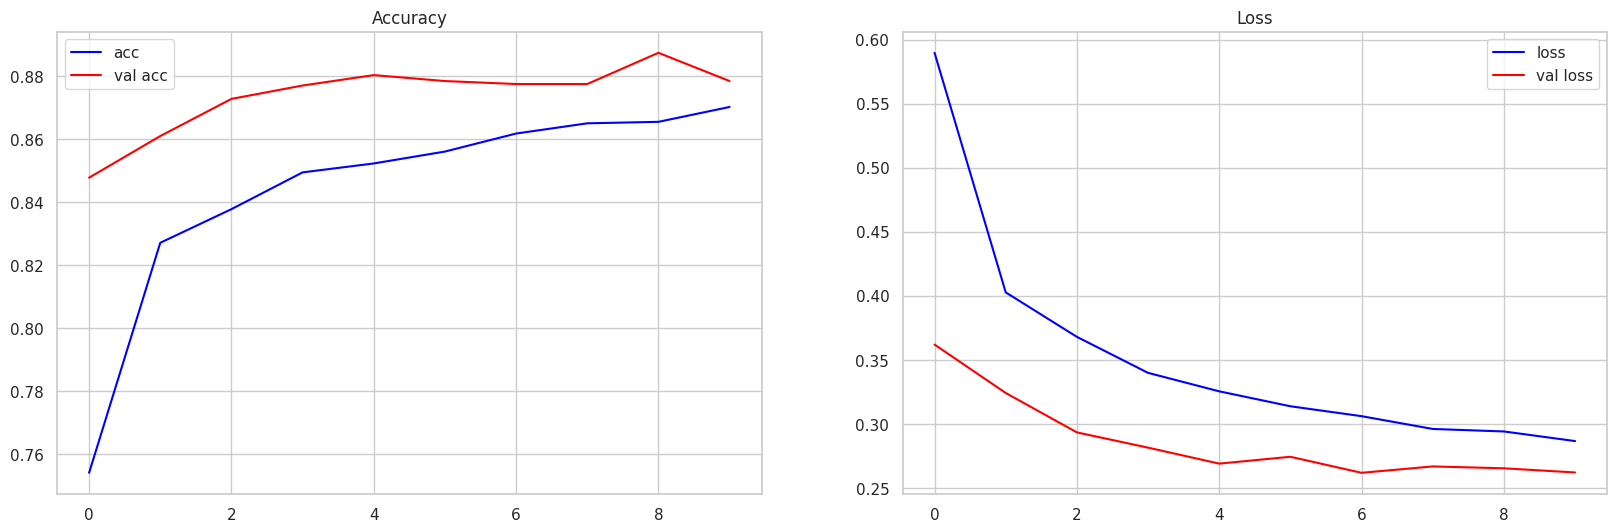

In [15]:
epoch_viewer(history)

In [17]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

pred_labels, true_labels = predict(model, valid_loader, device)

# Obtenir les noms des classes
target_names = valid_loader.dataset.classes

# Rapport
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))


Classification Report:

                 precision    recall  f1-score   support

          COVID       0.86      0.93      0.89       361
   Lung_Opacity       0.81      0.87      0.84       601
         Normal       0.92      0.86      0.89      1019
Viral Pneumonia       0.91      0.95      0.93       135

       accuracy                           0.88      2116
      macro avg       0.88      0.90      0.89      2116
   weighted avg       0.88      0.88      0.88      2116



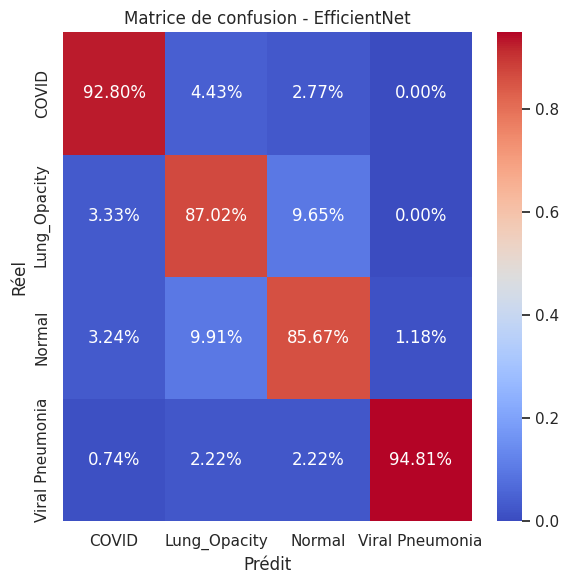

In [18]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

In [25]:
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def objective(trial):
    # Hyperparams
    dropout1 = trial.suggest_float("dropout1", 0.2, 0.6, step=0.1)
    dropout2 = trial.suggest_float("dropout2", 0.2, 0.6, step=0.1)
    dense1 = trial.suggest_int("dense1", 512, 4096, step=512)
    dense2 = trial.suggest_int("dense2", 128, 2048, step=128)
    lr = trial.suggest_categorical("lr", [1e-4, 3e-4, 1e-3])
    fine_tune = trial.suggest_categorical("fine_tune", [True, False])

    # Base model
    base_model = models.efficientnet_b0(pretrained=True)
    if not fine_tune:
        for param in base_model.parameters():
            param.requires_grad = False

    num_features = base_model.classifier[1].in_features
    base_model.classifier = nn.Sequential(
        nn.BatchNorm1d(num_features),
        nn.Linear(num_features, dense1),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(dense1, dense2),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(dense2, 4)  # <- adapte pour ton nombre de classes
    )

    model = base_model.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Mini-training (ex: 2-3 epochs pour aller vite)
    _, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=valid_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=None,
        epochs=3,
        device=device
    )    

    # Utilise la dernière validation accuracy pour l’objective
    return history["val_accuracy"][-1]


In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-06-25 09:51:39,762] A new study created in memory with name: no-name-4fc756c1-922e-408a-82cb-d4daaa0f7ff5


Epoch 1/3 | Train Loss: 0.5401 | Acc: 0.7794 | Val Loss: 0.3642 | Val Acc: 0.8407
Epoch 2/3 | Train Loss: 0.4439 | Acc: 0.8148 | Val Loss: 0.3511 | Val Acc: 0.8663


[I 2025-06-25 09:58:46,273] Trial 0 finished with value: 0.8497164461247637 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'dense1': 3584, 'dense2': 1920, 'lr': 0.001, 'fine_tune': False}. Best is trial 0 with value: 0.8497164461247637.


Epoch 3/3 | Train Loss: 0.4111 | Acc: 0.8295 | Val Loss: 0.4383 | Val Acc: 0.8497
Epoch 1/3 | Train Loss: 0.5579 | Acc: 0.7688 | Val Loss: 0.3232 | Val Acc: 0.8526
Epoch 2/3 | Train Loss: 0.3835 | Acc: 0.8334 | Val Loss: 0.3005 | Val Acc: 0.8724


[I 2025-06-25 10:05:22,828] Trial 1 finished with value: 0.8809073724007561 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dense1': 512, 'dense2': 640, 'lr': 0.0001, 'fine_tune': False}. Best is trial 1 with value: 0.8809073724007561.


Epoch 3/3 | Train Loss: 0.3499 | Acc: 0.8436 | Val Loss: 0.2723 | Val Acc: 0.8809
Epoch 1/3 | Train Loss: 0.6295 | Acc: 0.7729 | Val Loss: 0.3840 | Val Acc: 0.8129
Epoch 2/3 | Train Loss: 0.4896 | Acc: 0.8244 | Val Loss: 0.2976 | Val Acc: 0.8889


[I 2025-06-25 10:15:16,642] Trial 2 finished with value: 0.8478260869565217 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense1': 1536, 'dense2': 1024, 'lr': 0.001, 'fine_tune': True}. Best is trial 1 with value: 0.8809073724007561.


Epoch 3/3 | Train Loss: 0.5143 | Acc: 0.8230 | Val Loss: 0.3453 | Val Acc: 0.8478
Epoch 1/3 | Train Loss: 0.4797 | Acc: 0.7928 | Val Loss: 0.3258 | Val Acc: 0.8596
Epoch 2/3 | Train Loss: 0.3548 | Acc: 0.8386 | Val Loss: 0.3236 | Val Acc: 0.8748


[I 2025-06-25 10:22:01,934] Trial 3 finished with value: 0.8799621928166351 and parameters: {'dropout1': 0.5, 'dropout2': 0.2, 'dense1': 3072, 'dense2': 1536, 'lr': 0.0001, 'fine_tune': False}. Best is trial 1 with value: 0.8809073724007561.


Epoch 3/3 | Train Loss: 0.3235 | Acc: 0.8562 | Val Loss: 0.2777 | Val Acc: 0.8800
Epoch 1/3 | Train Loss: 0.3245 | Acc: 0.8645 | Val Loss: 0.1719 | Val Acc: 0.9074
Epoch 2/3 | Train Loss: 0.1829 | Acc: 0.9197 | Val Loss: 0.1540 | Val Acc: 0.9433


[I 2025-06-25 10:31:57,340] Trial 4 finished with value: 0.9480151228733459 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'dense1': 3072, 'dense2': 768, 'lr': 0.0001, 'fine_tune': True}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.1509 | Acc: 0.9326 | Val Loss: 0.1563 | Val Acc: 0.9480
Epoch 1/3 | Train Loss: 0.3631 | Acc: 0.8513 | Val Loss: 0.1562 | Val Acc: 0.9277
Epoch 2/3 | Train Loss: 0.2029 | Acc: 0.9143 | Val Loss: 0.1406 | Val Acc: 0.9428


[I 2025-06-25 10:41:50,380] Trial 5 finished with value: 0.9447069943289225 and parameters: {'dropout1': 0.5, 'dropout2': 0.4, 'dense1': 512, 'dense2': 256, 'lr': 0.0001, 'fine_tune': True}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.1477 | Acc: 0.9344 | Val Loss: 0.1260 | Val Acc: 0.9447
Epoch 1/3 | Train Loss: 0.3260 | Acc: 0.8653 | Val Loss: 0.1844 | Val Acc: 0.9315
Epoch 2/3 | Train Loss: 0.1826 | Acc: 0.9216 | Val Loss: 0.1595 | Val Acc: 0.9409


[I 2025-06-25 10:52:06,975] Trial 6 finished with value: 0.9447069943289225 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dense1': 3584, 'dense2': 1280, 'lr': 0.0001, 'fine_tune': True}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.1460 | Acc: 0.9373 | Val Loss: 0.1757 | Val Acc: 0.9447
Epoch 1/3 | Train Loss: 0.4964 | Acc: 0.7890 | Val Loss: 0.3394 | Val Acc: 0.8464
Epoch 2/3 | Train Loss: 0.3861 | Acc: 0.8333 | Val Loss: 0.2910 | Val Acc: 0.8767


[I 2025-06-25 10:59:03,522] Trial 7 finished with value: 0.861531190926276 and parameters: {'dropout1': 0.6, 'dropout2': 0.30000000000000004, 'dense1': 4096, 'dense2': 1920, 'lr': 0.0003, 'fine_tune': False}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.3567 | Acc: 0.8447 | Val Loss: 0.2865 | Val Acc: 0.8615
Epoch 1/3 | Train Loss: 0.4809 | Acc: 0.7899 | Val Loss: 0.3463 | Val Acc: 0.8615
Epoch 2/3 | Train Loss: 0.3490 | Acc: 0.8456 | Val Loss: 0.3024 | Val Acc: 0.8634


[I 2025-06-25 11:05:44,926] Trial 8 finished with value: 0.888468809073724 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense1': 2560, 'dense2': 640, 'lr': 0.0001, 'fine_tune': False}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.3224 | Acc: 0.8559 | Val Loss: 0.2780 | Val Acc: 0.8885
Epoch 1/3 | Train Loss: 0.3471 | Acc: 0.8583 | Val Loss: 0.1861 | Val Acc: 0.9381
Epoch 2/3 | Train Loss: 0.2452 | Acc: 0.9024 | Val Loss: 0.1757 | Val Acc: 0.9371


[I 2025-06-25 11:15:46,585] Trial 9 finished with value: 0.9045368620037807 and parameters: {'dropout1': 0.2, 'dropout2': 0.4, 'dense1': 2560, 'dense2': 2048, 'lr': 0.0003, 'fine_tune': True}. Best is trial 4 with value: 0.9480151228733459.


Epoch 3/3 | Train Loss: 0.2117 | Acc: 0.9164 | Val Loss: 0.2552 | Val Acc: 0.9045


In [27]:
print("Best params:", study.best_params)
print("Best val acc:", study.best_value)

Best params: {'dropout1': 0.5, 'dropout2': 0.5, 'dense1': 3072, 'dense2': 768, 'lr': 0.0001, 'fine_tune': True}
Best val acc: 0.9480151228733459


In [31]:
class EfficientNetClassifierOptimized(nn.Module):
    def __init__(self, num_classes=4, fine_tune=False):
        super(EfficientNetClassifierOptimized, self).__init__()

        # Charger EfficientNetB0 avec poids ImageNet
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        self.base_model = efficientnet_b0(weights=weights)

        # Geler ou dégeler le backbone
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune

        # Extraire la taille de sortie du backbone
        in_features = self.base_model.classifier[1].in_features

        # Remplacer le classifieur final
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 3072),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(3072, 768),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(768, 4)
        )

        self.base_model.classifier = nn.Identity()

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


In [32]:
model = EfficientNetClassifierOptimized(num_classes=4, fine_tune = True).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, cooldown=4)
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    device=device
)

Epoch 1/10 | Train Loss: 0.3318 | Acc: 0.8627 | Val Loss: 0.1833 | Val Acc: 0.9093
Epoch 2/10 | Train Loss: 0.1857 | Acc: 0.9177 | Val Loss: 0.1539 | Val Acc: 0.9419
Epoch 3/10 | Train Loss: 0.1465 | Acc: 0.9354 | Val Loss: 0.1438 | Val Acc: 0.9381
Epoch 4/10 | Train Loss: 0.1305 | Acc: 0.9428 | Val Loss: 0.1269 | Val Acc: 0.9513
Epoch 5/10 | Train Loss: 0.1099 | Acc: 0.9519 | Val Loss: 0.1281 | Val Acc: 0.9348
Epoch 6/10 | Train Loss: 0.0981 | Acc: 0.9582 | Val Loss: 0.1298 | Val Acc: 0.9494
Epoch 7/10 | Train Loss: 0.0941 | Acc: 0.9591 | Val Loss: 0.1140 | Val Acc: 0.9513
Epoch 8/10 | Train Loss: 0.0873 | Acc: 0.9623 | Val Loss: 0.1661 | Val Acc: 0.9494
Epoch 9/10 | Train Loss: 0.0698 | Acc: 0.9700 | Val Loss: 0.1495 | Val Acc: 0.9499
Epoch 10/10 | Train Loss: 0.0722 | Acc: 0.9686 | Val Loss: 0.1561 | Val Acc: 0.9513


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

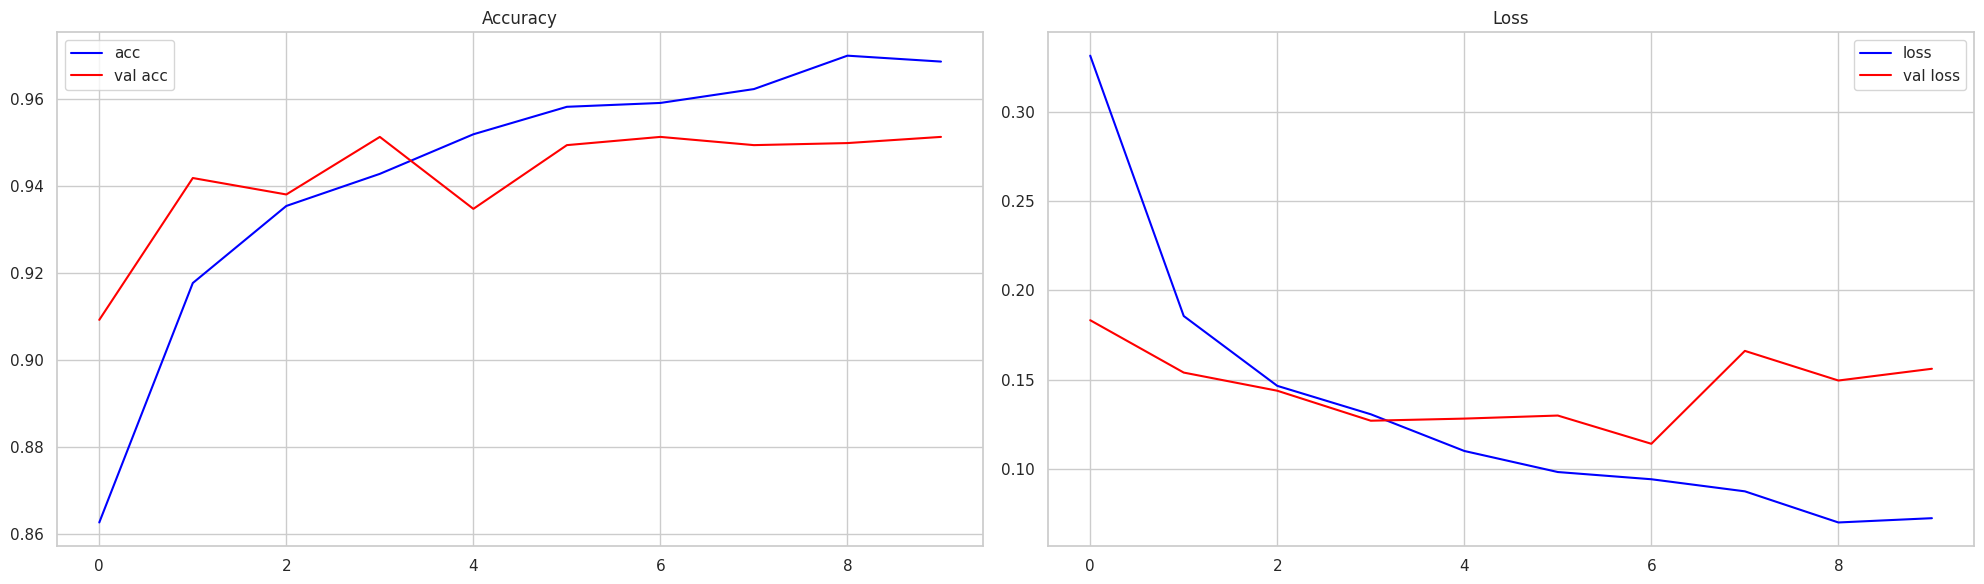

In [35]:
epoch_viewer(history)

In [36]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

pred_labels, true_labels = predict(model, valid_loader, device)

# Obtenir les noms des classes
target_names = valid_loader.dataset.classes

# Rapport
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))

Classification Report:

                 precision    recall  f1-score   support

          COVID       0.99      0.99      0.99       361
   Lung_Opacity       0.95      0.91      0.93       601
         Normal       0.95      0.96      0.95      1019
Viral Pneumonia       0.92      1.00      0.96       135

       accuracy                           0.95      2116
      macro avg       0.95      0.96      0.96      2116
   weighted avg       0.95      0.95      0.95      2116



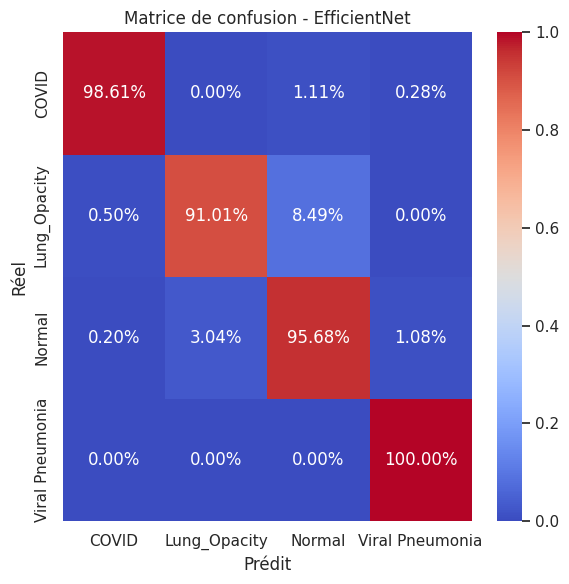

In [37]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

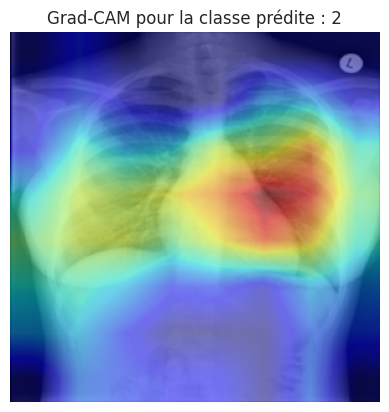

In [49]:
img_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-2.png"
img = Image.open(img_path).convert("RGB")

# Même preprocessing que dans le modèle
transform = Compose([
    Resize((240, 240)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# GradCAM
cam_extractor = GradCAM(model, target_layer="base_model.features.7")  # Dernière couche conv de EfficientNetB0
out = model(input_tensor)
pred_class = out.argmax(dim=1).item()

# Extraire la CAM
activation_map = cam_extractor(pred_class, out)
heatmap = activation_map[0].squeeze().cpu().numpy()
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Afficher
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.axis('off')
plt.title(f"Grad-CAM pour la classe prédite : {pred_class}")
plt.show()


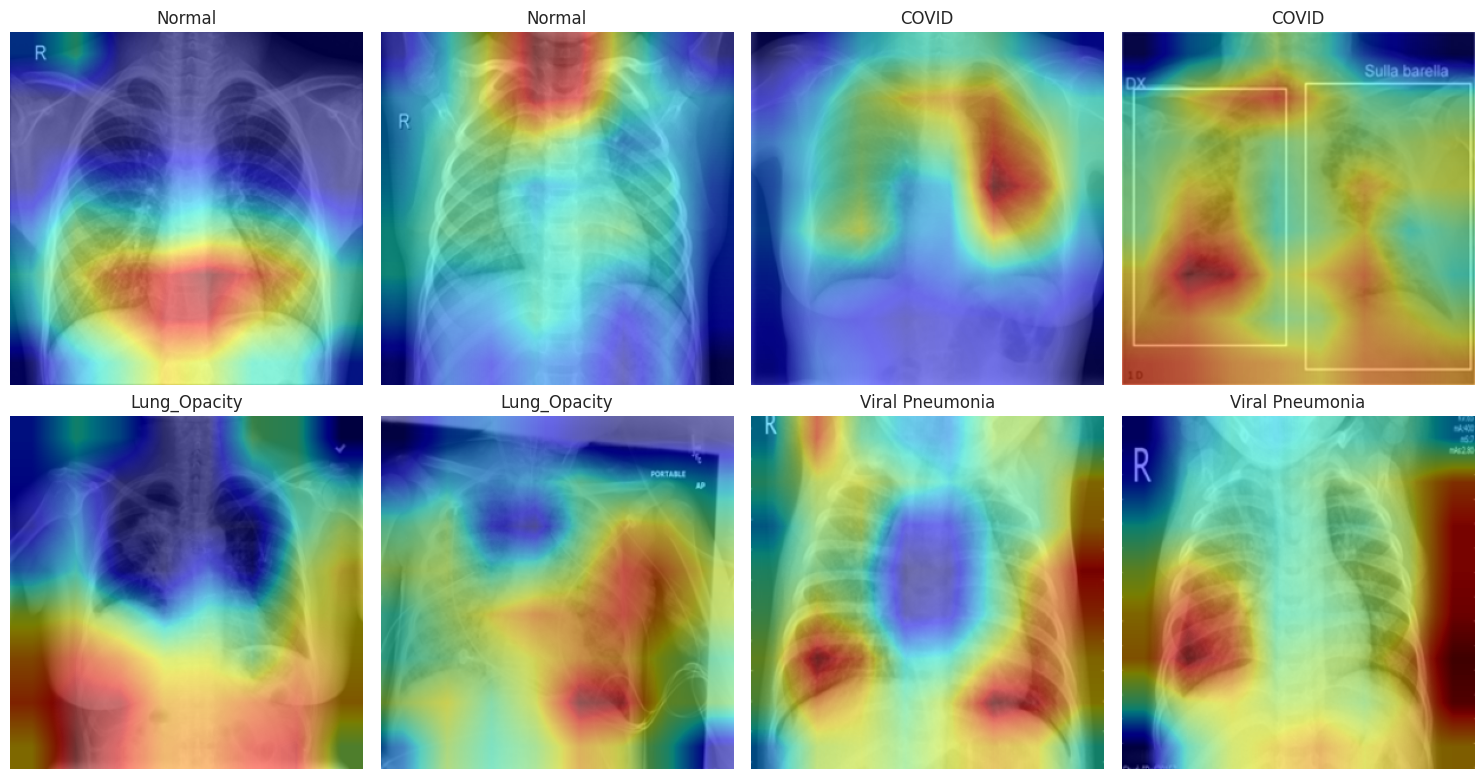

In [56]:
def show_gradcam_per_class(samples_per_class=2):
    base_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
    class_names = ["Normal", "COVID", "Lung_Opacity", "Viral Pneumonia"]
    
    # Stocker les images sélectionnées
    selected_images = {i: [] for i in range(len(class_names))}

    # Sélection d'images par classe
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(base_path, class_name, "images")
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith((".png", ".jpg"))]
        selected_images[class_idx] = image_files[:samples_per_class]

    total_plots = samples_per_class * len(class_names)
    plt.figure(figsize=(15, 4 * samples_per_class))

    plot_idx = 1
    for class_idx, image_paths in selected_images.items():
        for img_path in image_paths:
            img, heatmap = gradcamer(img_path)
            plt.subplot(samples_per_class, len(class_names), plot_idx)
            plt.imshow(img)
            plt.imshow(heatmap, alpha=0.5, cmap='jet')
            plt.axis('off')
            plt.title(f"{class_names[class_idx]}")
            plot_idx += 1

    plt.tight_layout()
    plt.show()

show_gradcam_per_class()

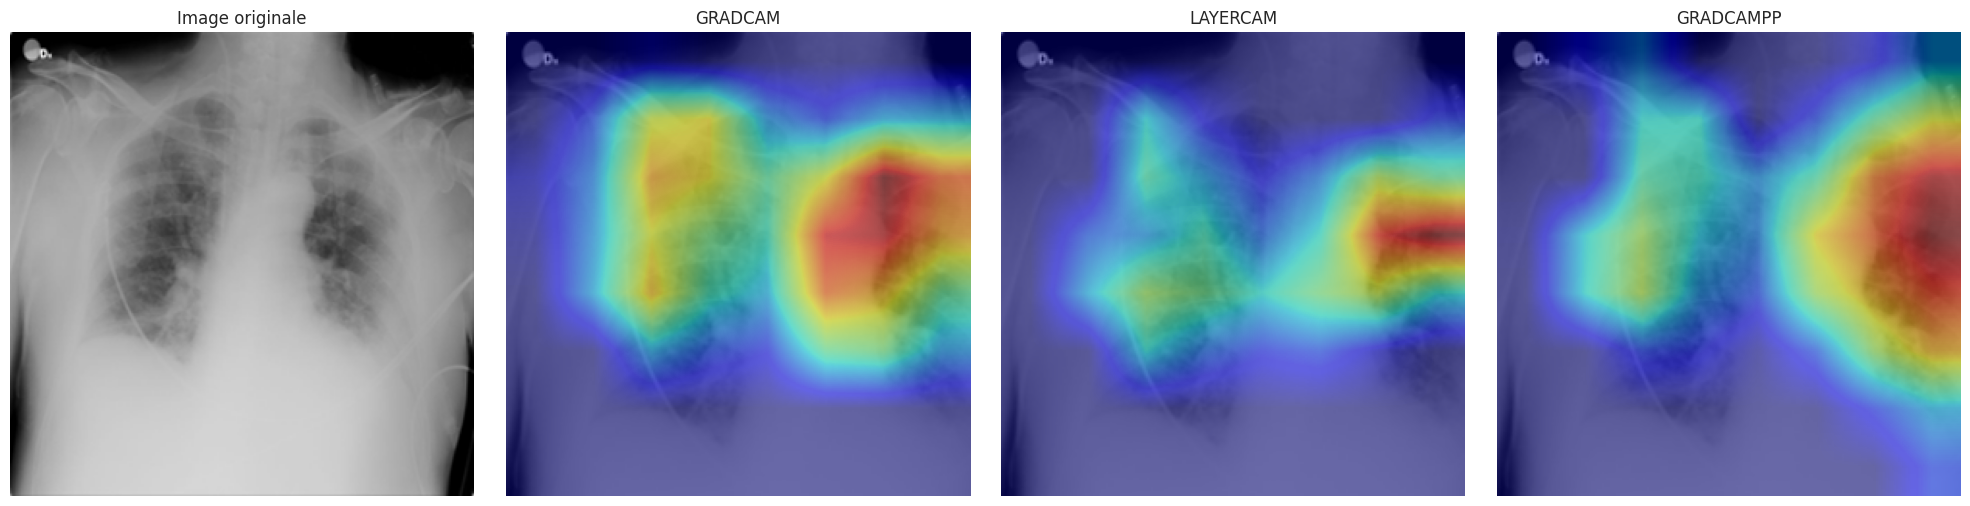

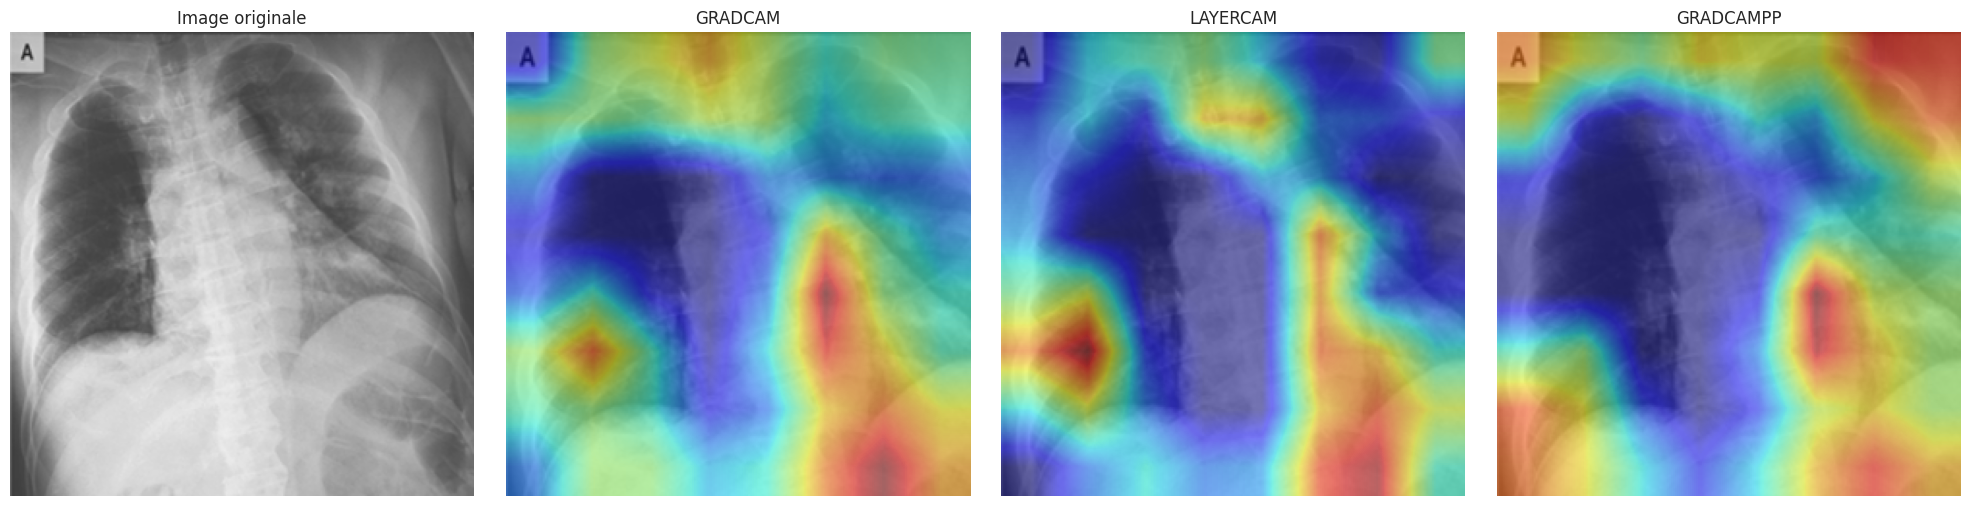

In [75]:
from torchcam.methods import GradCAM, SmoothGradCAMpp, ScoreCAM, GradCAMpp, LayerCAM, XGradCAM
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

def overlay_with_contours(img_pil, heatmap, alpha=0.5):
    """
    Affiche une image avec heatmap et contours superposés.
    
    Args:
        img_pil (PIL.Image): L’image de base.
        heatmap (np.ndarray): La carte d’activation normalisée (0–1).
        alpha (float): Opacité du heatmap.
    """
    img = np.array(img_pil.convert("RGB"))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

    # Générer contours à partir de la heatmap
    heatmap_uint8 = np.uint8(255 * heatmap)
    contours, _ = cv2.findContours(heatmap_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tracer les contours sur l’overlay
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), thickness=2)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title("Overlay avec contours")
    plt.axis("off")
    plt.show()
    
def compute_cam(method, model, input_tensor, target_layer, pred_class):
    cam_methods = {
        "gradcam": GradCAM,
        "layercam": LayerCAM,
        "gradcampp": GradCAMpp,
        "xgradcam": XGradCAM
    }

    cam_class = cam_methods[method.lower()]
    cam_extractor = cam_class(model, target_layer=target_layer)

    if method.lower() != "scorecam":
        input_tensor.requires_grad_()
        
    activation_map = cam_extractor(pred_class, model(input_tensor))
    
    heatmap = activation_map[0].squeeze().cpu().numpy()
    heatmap = cv2.resize(heatmap, (input_tensor.shape[3], input_tensor.shape[2]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    return heatmap

def compare_cam_methods(img_path, model, target_layer="base_model.features.7", device="cuda"):
    # Préparer l’image
    img = Image.open(img_path).convert("RGB")
    transform = Compose([
        Resize((240, 240)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Prédiction
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    # Générer les heatmaps
    heatmaps = {}
    for method in ["gradcam", "layercam", "gradcampp"]:
        try:
            heatmaps[method] = compute_cam(method, model, input_tensor, target_layer, pred_class)
        except Exception as e:
            print(f"Erreur avec {method}: {e}")
            heatmaps[method] = None

    # Affichage
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[0].set_title("Image originale")
    axes[0].axis('off')

    for i, method in enumerate(["gradcam", "layercam", "gradcampp"]):
        axes[i + 1].imshow(img)
        if heatmaps[method] is not None:
            axes[i + 1].imshow(heatmaps[method], alpha=0.5, cmap='jet')
        axes[i + 1].set_title(method.upper())
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

compare_cam_methods(
    img_path="/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png",
    model=model,
    target_layer="base_model.features.7",
    device=device
)

compare_cam_methods(
    img_path="/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2.png",
    model=model,
    target_layer="base_model.features.7",
    device=device
)